# Single-cell differentiation

This example uses TACCO to predict the fate of single cells in a hematopoietic setting comparing against experimental ground truth (Weinreb et al.) and other methods.

(Weinreb et al.): Weinreb C, Rodriguez-Fraticelli A, Camargo FD, Klein AM. Lineage tracing on transcriptional landscapes links state to fate during differentiation. Science. 2020 Feb 14;367(6479):eaaw3381. doi: 10.1126/science.aaw3381. Epub 2020 Jan 23. PMID: 31974159; PMCID: PMC7608074.

In [1]:
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import anndata as ad

import tacco as tc

# The notebook expects to be executed either in the workflow directory or in the repository root folder...
sys.path.insert(1, os.path.abspath('workflow' if os.path.exists('workflow/common_code.py') else '..')) 
import common_code

## Load data

In [2]:
data_path = common_code.find_path('results/single_cell_differentiation/data')
plot_path = common_code.find_path('results/single_cell_differentiation')
env_path = common_code.find_path('results/env_links')

In [3]:
d4d6 = ad.read(f'{data_path}/d4_d6_differentiation.h5ad')

In [4]:
d2 = ad.read(f'{data_path}/d2_differentiation.h5ad')

## Plotting options

In [5]:
highres = False
default_dpi = 100.0 # matplotlib.rcParams['figure.dpi']
if highres:
    matplotlib.rcParams['figure.dpi'] = 648.0
    hr_ext = '_hd'
else:
    matplotlib.rcParams['figure.dpi'] = default_dpi
    hr_ext = ''

axsize = np.array([4,3])*0.5

x = 'SPRING-x'
y = 'SPRING-y'

dummy_val = 'dummy'
only_gray = {dummy_val:'#CCCCCC'}
color_dict = {
    'Neutrophil': '#e9ff00',
    'Erythroid': '#5a00ff',
    'Monocyte': '#0039ff',
    'Meg': '#00ff00',
    'Mast': '#ff00a3',
    'Baso': '#ff8100',
    'Lymphoid': '#00caff',
    'Eos': '#eb00ff',
    'Ccr7_DC': '#00ff00',
    'pDC': '#00faa4',
}

## Run fate prediction

Use a set of different methods for comparison

In [6]:
method_configs = {
    'TACCO':   { 'method': 'OT', 'multi_center': 10, }, # multi_center=10 takes into account variation within a single class
    'WOT':     { 'method': 'WOT', },
    'SVM':     { 'method': 'svm', },
    'NMFreg':  { 'method': 'NMFreg', },
    'SingleR': { 'method': 'SingleR', 'conda_env': f'{env_path}/SingleR_env', },
    'RCTD':    { 'method': 'RCTD', 'conda_env': f'{env_path}/RCTD_env', },
}
benchmark_results = {}
for method, params in method_configs.items():
    print(f'running method {method!r}')
    tc.tl.annotate(d2, d4d6, annotation_key='Cell type annotation', result_key=method, **method_configs[method], assume_valid_counts=True,)
plt.close("all") # suppress side-effect plots from NMFreg

running method 'TACCO'
Starting preprocessing
Annotation profiles were not found in `reference.varm["Cell type annotation"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 2.22 seconds.
Starting annotation of data with shape (975, 16620) and a reference of shape (9165, 16620) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=Cell type annotation, normalize_to=adata
   +- multi center: multi_center=10 multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  0.22513030871120335 0.42410762735263485
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 12.14 seconds.
running me

## Plot results

Plot gray background of day 2 data when showing annotation of day 4 and day 6 data and vice versa. 

In [7]:
joint = ad.concat([d2,d4d6],)
for method in method_configs.keys():
    joint.obsm[method] = d2.obsm[method].reindex(joint.obs.index)
joint.obsm['type_2'] = d2.obsm['clone_fate'].reindex(joint.obs.index)
joint.obs['type_46'] = d4d6.obs['Cell type annotation'].reindex(joint.obs.index)
dummy_key = tc.utils.find_unused_key(joint.obs)
joint.obs[dummy_key] = dummy_val

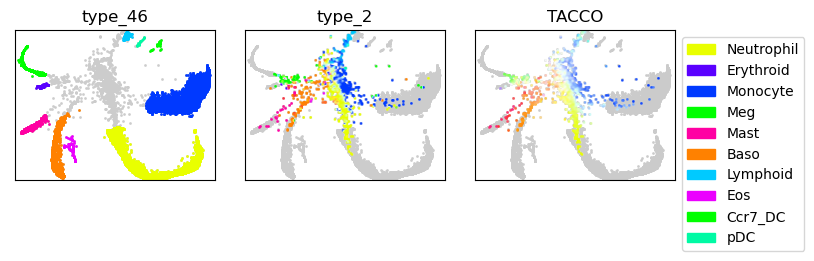

In [8]:
fig,axs = tc.pl.subplots(3, axsize=axsize)

tc.pl.scatter(joint, joint=True, position_key=[x,y], ax=axs[0,0], legend=False, point_size=3, keys=dummy_key, colors=only_gray, noticks=True)
tc.pl.scatter(joint, joint=True, position_key=[x,y], ax=axs[0,0], legend=False, point_size=3, keys='type_46', colors=color_dict, noticks=True)

tc.pl.scatter(joint, joint=True, position_key=[x,y], ax=axs[0,1], legend=False, point_size=3, keys=dummy_key, colors=only_gray, noticks=True)
tc.pl.scatter(joint, joint=True, position_key=[x,y], ax=axs[0,1], legend=False, point_size=3, keys='type_2',  colors=color_dict, noticks=True)

tc.pl.scatter(joint, joint=True, position_key=[x,y], ax=axs[0,2], legend=False, point_size=3, keys=dummy_key, colors=only_gray, noticks=True)
tc.pl.scatter(joint, joint=True, position_key=[x,y], ax=axs[0,2], legend=True,  point_size=3, keys='TACCO',  colors=color_dict, noticks=True)

fig.savefig(f'{plot_path}/differentiation_spring{hr_ext}.pdf',bbox_inches='tight')

Show the annotations of all methods

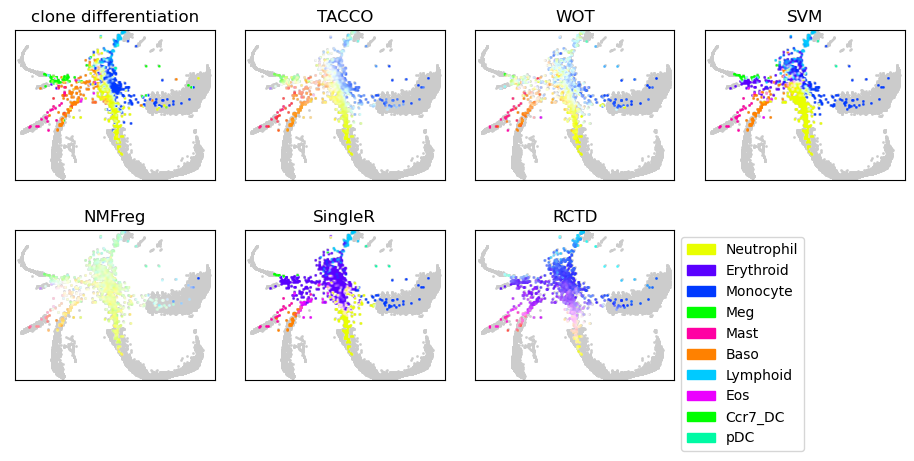

In [9]:
n_panels = len(method_configs)+1
fig,axs = tc.pl.subplots((n_panels+1)//2, 2, axsize=axsize, y_padding=0.5)
axs = axs.flatten()

tc.pl.scatter(joint, joint=True, position_key=[x,y], ax=axs[0], legend=False, point_size=3, keys=dummy_key, colors=only_gray, noticks=True)
tc.pl.scatter(joint, joint=True, position_key=[x,y], ax=axs[0], legend=False, point_size=3, keys='type_2',  colors=color_dict, noticks=True)
axs[0].set_title('clone differentiation')

for i_method,method in enumerate(method_configs.keys()):
    tc.pl.scatter(joint, joint=True, position_key=[x,y], ax=axs[i_method+1], legend=False, point_size=3, keys=dummy_key, colors=only_gray, noticks=True)
    tc.pl.scatter(joint, joint=True, position_key=[x,y], ax=axs[i_method+1], legend=(i_method == len(method_configs)-1),  point_size=3, keys=method,  colors=color_dict, noticks=True)
    axs[i_method+1].set_title(method)
if len(method_configs) + 1 != len(axs):
    axs[-1].axis('off')

fig.savefig(f'{plot_path}/differentiation_d2_supp{hr_ext}.pdf',bbox_inches='tight')